In [1]:
%matplotlib inline
import multiprocessing

from brian2 import *
prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!

import bluepyopt as bpop
from bluepyopt.parameters import Parameter

import os

In [2]:
# base directory of the project
SWBasePath = os.path.sep.join(os.path.abspath('__file__').split(os.path.sep)[:-2])
# add the 'scripts' directory to the path. now we can import the modules in there
sys.path.insert(0, os.path.sep.join([SWBasePath, 'scripts']))

from detect_oscillations import *

In [3]:
fIn = 'wmxR_asym.txt'
fName = os.path.join(SWBasePath, 'files', fIn)
Wee = np.genfromtxt(fName) * 1.e9 * 5.0
np.fill_diagonal(Wee, 0)
Wee = Wee.flatten()

NE = 4000
NI = 1000

# sparseness
eps_pyr = 0.16
eps_bas = 0.4

In [4]:
# parameters for pyr cells
pyr_params = np.genfromtxt('pyr_params.param')

z           = 1*nS
gL_Pyr      = pyr_params[0]     * uS
tauMem_Pyr  = pyr_params[1]     * ms
Cm_Pyr      = tauMem_Pyr * gL_Pyr
Vrest_Pyr   = pyr_params[2]     * mV
reset_Pyr   = pyr_params[3]     * mV
theta_Pyr   = pyr_params[4]     * mV
tref_Pyr    = pyr_params[5]     * ms

# Adaptation parameters for pyr cells
a_Pyr       = pyr_params[6] * nS              # nS    Subthreshold adaptation conductance
b_Pyr       = pyr_params[7] * nA              # nA    Spike-triggered adaptation
delta_T_Pyr = pyr_params[8] * mV              # Slope factor
tau_w_Pyr   = pyr_params[9] * ms              # Adaptation time constant
v_spike_Pyr = theta_Pyr + 10 * delta_T_Pyr

In [5]:
# parameters for bas cells
bas_params = np.genfromtxt('bas_params.param')

gL_Bas      = bas_params[0] * uS
tauMem_Bas  = bas_params[1] * ms
Cm_Bas      = tauMem_Bas * gL_Bas
Vrest_Bas   = bas_params[2] * mV
reset_Bas   = bas_params[3] * mV
theta_Bas   = bas_params[4] * mV
tref_Bas    = bas_params[5] * ms

# Adaptation parameters for pyr cells
a_Bas       = bas_params[6] * nS              # nS    Subthreshold adaptation conductance
b_Bas       = bas_params[7] * nA              # nA    Spike-triggered adaptation
delta_T_Bas = bas_params[8] * mV              # Slope factor
tau_w_Bas   = bas_params[9] * ms              # Adaptation time constant
v_spike_Bas = theta_Bas + 10 * delta_T_Bas

In [6]:
def run_sim(parameters):
    # synaptic weights
    J_PyrInh = parameters['J_PyrInh']
    J_BasExc = parameters['J_BasExc']
    J_BasInh = parameters['J_BasInh']

    # Synaptic reversal potentials
    E_Exc = 0.0*mV
    E_Inh = -70.0*mV

    # Synaptic delays
    delay_PyrExc = 4.2*ms
    delay_PyrInh = 1.1*ms
    delay_BasExc = 0.5*ms# * 0.67
    delay_BasInh = 0.6*ms# * 0.67
    # delay_PyrExc = 3.0*ms
    # delay_PyrInh = 1.5*ms * 1.3
    # delay_BasExc = 3.0*ms
    # delay_BasInh = 1.5*ms * 0.6 #* 0.55

    # Synaptic decays -- values the same as for the simple exponential synapse
    # PyrExc_decay = 10.0*ms
    # PyrInh_decay = 3.0*ms * 1.1
    # BasExc_decay = 3.0*ms
    # BasInh_decay = 1.5*ms * 0.67

    # Synaptic decays -- two parameter sets from somewhere
    PyrExc_decay = 4.8  * ms # unified cikk
    PyrInh_decay = 3.3  * ms
    BasExc_decay = 2.0  * ms # unified cikk
    BasInh_decay = 1.2  * ms

    # PyrExc_decay = 2.5 * ms
    # PyrInh_decay = 4.0 * ms
    # BasExc_decay = 2.0 * ms
    # BasInh_decay = 2.5 * ms

    # Synaptic rises -- two parameter sets from somewhere
    PyrExc_rise = 0.6  * ms # unified cikk
    PyrInh_rise = 0.35 * ms
    BasExc_rise = 0.35 * ms # unified cikk
    BasInh_rise = 0.3  * ms

    # PyrExc_rise = 0.5  * ms
    # PyrInh_rise = 0.3  * ms
    # BasExc_rise = 0.35 * ms
    # BasInh_rise = 0.4  * ms


    # Normalization factors -- they normalize the peak of the curve to 1
    invpeak_PyrExc = (PyrExc_decay / PyrExc_rise) ** (PyrExc_rise / (PyrExc_decay - PyrExc_rise))

    invpeak_PyrInh = (PyrInh_decay / PyrInh_rise) ** (PyrInh_rise / (PyrInh_decay - PyrInh_rise))

    invpeak_BasExc = (BasExc_decay / BasExc_rise) ** (BasExc_rise / (BasExc_decay - BasExc_rise))

    invpeak_BasInh = (BasInh_decay / BasInh_rise) ** (BasInh_rise / (BasInh_decay - BasInh_rise))



    # input parameters
    p_rate_mf = 25. * Hz #5. * Hz #25.*Hz
    J_PyrMF = 30. #45.5 #18.
    
    eqs_adexp = '''
    dvm/dt = (-gL_Pyr*(vm-Vrest_Pyr) + gL_Pyr*delta_T_Pyr*exp((vm- theta_Pyr)/delta_T_Pyr)-w - (g_ampa*z*(vm-E_Exc) + g_gaba*z*(vm-E_Inh)))/Cm_Pyr : volt (unless refractory)
    dw/dt = (a_Pyr*(vm- Vrest_Pyr )-w)/tau_w_Pyr : amp
    dg_ampa/dt = (invpeak_PyrExc * x_ampa - g_ampa) / PyrExc_rise : 1
    dx_ampa/dt = -x_ampa / PyrExc_decay : 1
    dg_gaba/dt = (invpeak_PyrInh * x_gaba - g_gaba) / PyrInh_rise : 1
    dx_gaba/dt = -x_gaba/PyrInh_decay : 1
    '''

    reset_pyr = '''
    vm = reset_Pyr
    w += b_Pyr
    '''

    eqs_bas = '''
    dvm/dt = (-gL_Bas*(vm-Vrest_Bas) + gL_Bas*delta_T_Bas*exp((vm- theta_Bas)/delta_T_Bas)-w - (g_ampa*z*(vm-E_Exc) + g_gaba*z*(vm-E_Inh)))/Cm_Bas : volt (unless refractory)
    dw/dt = (a_Bas*(vm- Vrest_Bas )-w)/tau_w_Bas : amp
    dg_ampa/dt = (invpeak_BasExc * x_ampa - g_ampa) / BasExc_rise : 1
    dx_ampa/dt = -x_ampa/BasExc_decay : 1
    dg_gaba/dt = (invpeak_BasInh * x_gaba - g_gaba) / BasInh_rise : 1
    dx_gaba/dt = -x_gaba/BasInh_decay : 1
    '''

    reset_bas = '''
    vm = reset_Bas
    w += b_Bas
    '''
    
    PE = NeuronGroup(NE, model=eqs_adexp, threshold='vm > v_spike_Pyr', reset=reset_pyr, refractory=tref_Pyr, method='exponential_euler')
    PI = NeuronGroup(NI, model=eqs_bas,   threshold='vm > v_spike_Bas', reset=reset_bas, refractory=tref_Bas, method='exponential_euler')

    PE.vm = Vrest_Pyr
    PE.g_ampa = 0
    PE.g_gaba = 0

    PI.vm  = Vrest_Bas
    PI.g_ampa = 0
    PI.g_gaba = 0

    MF = PoissonGroup(NE, p_rate_mf)
    
    # Poisson to Pyr
    Cext = Synapses(MF, PE, on_pre='x_ampa += J_PyrMF')#, method='rk4')
    Cext.connect(j='i')

    Cee = Synapses(PE, PE, 'w_exc : 1', on_pre='x_ampa += w_exc')#, method='rk4')
    Cee.connect()

    Cee.w_exc = Wee
    Cee.delay = delay_PyrExc

    # Pyr - Bas
    Cei = Synapses(PE, PI, on_pre='x_ampa += J_BasExc')#, method='rk4')
    Cei.connect(p=eps_pyr)
    Cei.delay = delay_BasExc

    # Bas - Pyr
    Cie = Synapses(PI, PE, on_pre='x_gaba += J_PyrInh')#, method='rk4')
    Cie.connect(p=eps_bas)
    Cie.delay = delay_PyrInh

    # Bas - Bas
    Cii = Synapses(PI, PI, on_pre='x_gaba += J_BasInh')#, method='rk4')
    Cii.connect(p=eps_bas)
    Cii.delay = delay_BasInh
    
    # Monitors
    sme = SpikeMonitor(PE)
    smi = SpikeMonitor(PI)
    popre = PopulationRateMonitor(PE)
    popri = PopulationRateMonitor(PI)
    
    # Run
    run(10*second)
    
    return sme, smi, popre, popri

In [7]:
class BrianEvaluator(bpop.evaluators.Evaluator):
    def __init__(self):
        super(BrianEvaluator, self).__init__(objectives=['score'],
                                             params=[Parameter('J_PyrInh', bounds=[0, 50]),
                                                     Parameter('J_BasExc', bounds=[0, 50]),
                                                     Parameter('J_BasInh', bounds=[0, 50])])
    
    def evaluate_with_dicts(self, param_dict):
        sme, smi, popre, popri = run_sim(param_dict)
        
        fitness = 0
        
        if sme.num_spikes > 0 and smi.num_spikes > 0:
            spikeTimesE, spikingNeuronsE, poprE, ISIhist, bin_edges = preprocess_monitors(sme, popre)
            spikeTimesI, spikingNeuronsI, poprI = preprocess_monitors(smi, popri, calc_ISI=False)

            avgReplayInterval = replay(ISIhist[3:16])  # bins from 150 to 850 (range of interest)

            meanEr, rEAC, maxEAC, tMaxEAC, maxEACR, tMaxEACR, fE, PxxE, avgRippleFE, ripplePE = ripple(poprE, 1000)
            avgGammaFE, gammaPE = gamma(fE, PxxE)
            meanIr, rIAC, maxIAC, tMaxIAC, maxIACR, tMaxIACR, fI, PxxI, avgRippleFI, ripplePI = ripple(poprI, 1000)
            avgGammaFI, gammaPI = gamma(fI, PxxI)
        
            fitness = - int(not np.isnan(avgReplayInterval)) * ((ripplePE/gammaPE) + (ripplePI/gammaPI) + int(np.isnan(avgGammaFE)) + int(np.isnan(avgGammaFI)))
        
        return {'score': fitness}
    
    def evaluate_with_lists(self, param_list):
        J_PyrInh, J_BasExc, J_BasInh = param_list
        param_dict = {'J_PyrInh': J_PyrInh, 'J_BasExc': J_BasExc, 'J_BasInh': J_BasInh}
        return [self.evaluate_with_dicts(param_dict)['score']]

In [8]:
pool = multiprocessing.Pool()
evaluator = BrianEvaluator()
opt = bpop.deapext.optimisations.DEAPOptimisation(evaluator, map_function=pool.map)
%time final_pop, hall_of_fame, logs, hist = opt.run(max_ngen=5)

Not replay
Not replay
Not replay
Not replay
Not replay
Not replay
Not replay
Replay, avg. replay interval: 261.690662321 [ms]
Not replay
Not replay
Not replay
Not replay
Not replay
Replay, avg. replay interval: 525.893546014 [ms]
Not replay
Not replay
Not replay
Not replay
Not replay
Not replay
Not replay
Not replay
Not replay
Replay, avg. replay interval: 488.724846894 [ms]
Not replay
Not replay
Replay, avg. replay interval: 525.284095248 [ms]
Replay, avg. replay interval: 425.004041617 [ms]
Not replay
Not replay
Not replay
Not replay
Not replay
Replay, avg. replay interval: 454.73663425 [ms]
Not replay
Replay, avg. replay interval: 525.223528377 [ms]
Replay, avg. replay interval: 489.989056069 [ms]
Replay, avg. replay interval: 525.439584003 [ms]
Not replay
Replay, avg. replay interval: 524.904555501 [ms]
Not replay
Not replay
Replay, avg. replay interval: 474.960362618 [ms]
Replay, avg. replay interval: 331.852708983 [ms]
Not replay
Replay, avg. replay interval: 526.00600357 [ms]
No

In [9]:
best_ind = hall_of_fame[0]
print 'Best individual: ', best_ind
print 'Fitness values: ', best_ind.fitness.values

Best individual:  [0.047714324330478064, 39.4953692752346, 7.703975679568074]
Fitness values:  (-3.3642861327179876,)


In [10]:
# Run the simulation for the best parameters
smer, smir, poprer, poprir = run_sim({'J_PyrInh' : best_ind[0], 'J_BasExc' : best_ind[1], 'J_BasInh' : best_ind[2]})

In [11]:
if smer.num_spikes > 0 and smir.num_spikes > 0:  # check if there is any activity
    spikeTimesE, spikingNeuronsE, poprE, ISIhist, bin_edges = preprocess_monitors(smer, poprer)
    spikeTimesI, spikingNeuronsI, poprI = preprocess_monitors(smir, poprir, calc_ISI=False)
    
    # calling detect_oscillation functions:
    avgReplayInterval = replay(ISIhist[3:16])  # bins from 150 to 850 (range of interest)

    meanEr, rEAC, maxEAC, tMaxEAC, maxEACR, tMaxEACR, fE, PxxE, avgRippleFE, ripplePE = ripple(poprE, 1000)
    avgGammaFE, gammaPE = gamma(fE, PxxE)
    meanIr, rIAC, maxIAC, tMaxIAC, maxIACR, tMaxIACR, fI, PxxI, avgRippleFI, ripplePI = ripple(poprI, 1000)
    avgGammaFI, gammaPI = gamma(fI, PxxI)

    # Print out some info
    print 'Mean excitatory rate: ', meanEr
    print 'Maximum exc. autocorrelation:', maxEAC, 'at', tMaxEAC, '[ms]'
    print 'Maximum exc. AC in ripple range:', maxEACR, 'at', tMaxEACR, '[ms]'
    print 'Mean inhibitory rate: ', meanIr
    print 'Maximum inh. autocorrelation:', maxIAC, 'at', tMaxIAC, '[ms]'
    print 'Maximum inh. AC in ripple range:', maxIACR, 'at', tMaxIACR, '[ms]'
    print ''
    print 'Average exc. ripple freq:', avgRippleFE
    print 'Exc. ripple power:', ripplePE
    print 'Average exc. gamma freq:', avgGammaFE
    print 'Exc. gamma power:', gammaPE
    print 'Average inh. ripple freq:', avgRippleFI
    print 'Inh. ripple power:', ripplePI
    print 'Average inh. gamma freq:', avgGammaFI
    print 'Inh. gamma power:', gammaPI
    print "--------------------------------------------------"

Replay, avg. replay interval: 491.805388708 [ms]
Mean excitatory rate:  3.270375
Maximum exc. autocorrelation: 0.757430105365 at 13 [ms]
Maximum exc. AC in ripple range: -0.0777503858327 at 3 [ms]
Mean inhibitory rate:  92.6487
Maximum inh. autocorrelation: 0.563193751419 at 13 [ms]
Maximum inh. AC in ripple range: 0.051128784313 at 6 [ms]

Average exc. ripple freq: 152.34375
Exc. ripple power: 18.0145952944
Average exc. gamma freq: 76.171875
Exc. gamma power: 52.5564808734
Average inh. ripple freq: nan
Inh. ripple power: 40.6083979017
Average inh. gamma freq: 80.078125
Inh. gamma power: 13.592601496
--------------------------------------------------


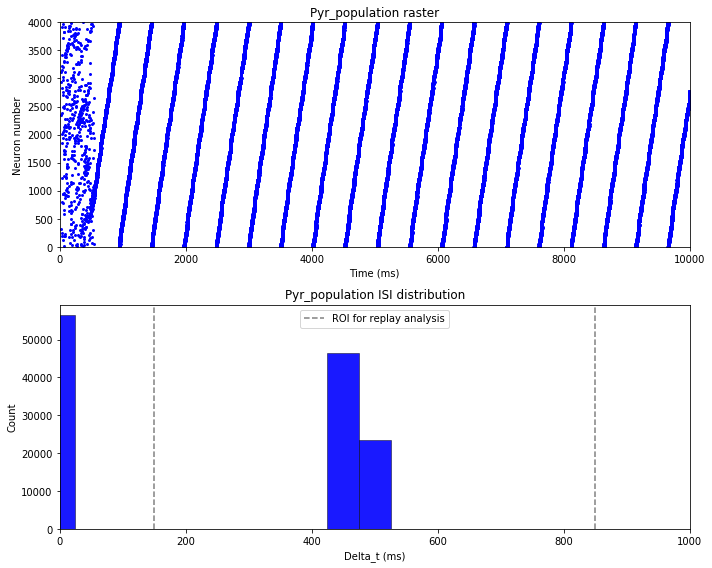

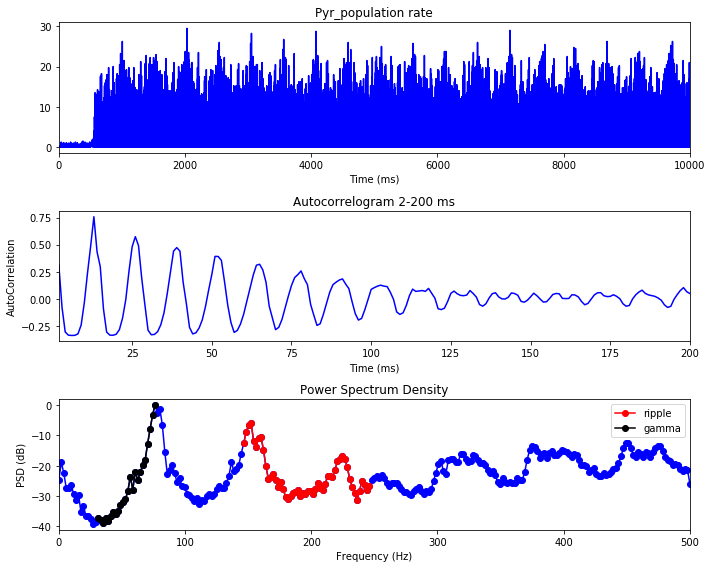

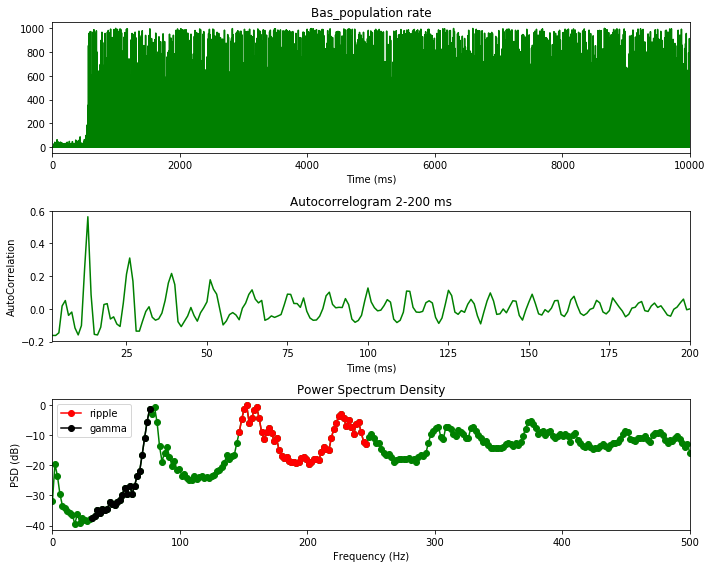

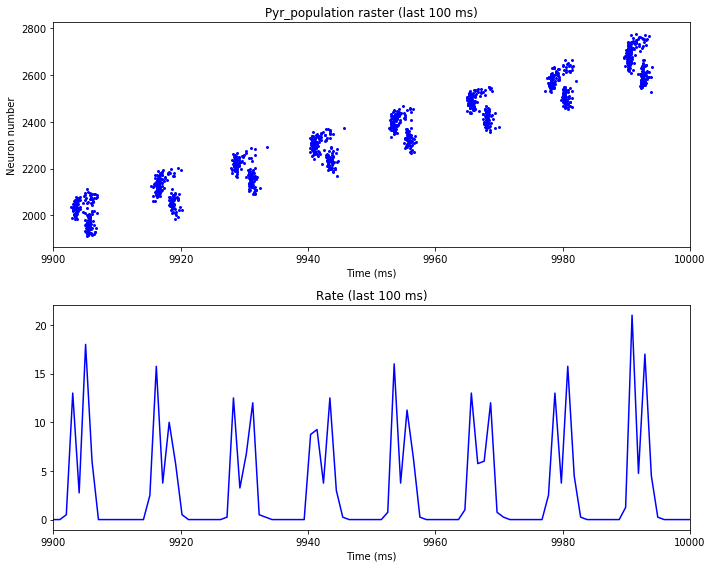

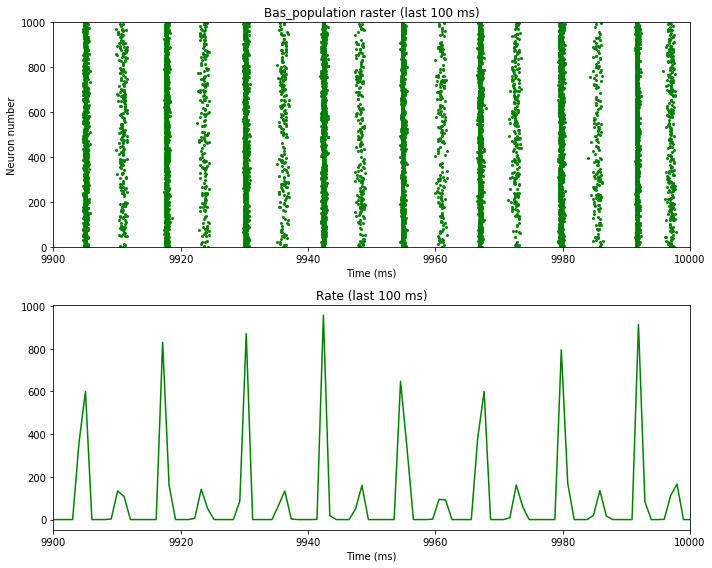

In [12]:
%matplotlib inline
from plots import *
if smer.num_spikes > 0 and smir.num_spikes > 0:
    plot_raster_ISI(spikeTimesE, spikingNeuronsE, [ISIhist, bin_edges], 'blue', multiplier_=1)
    plot_PSD(poprE, rEAC, fE, PxxE, "Pyr_population", 'b-', multiplier_=1)
    plot_PSD(poprI, rIAC, fI, PxxI, "Bas_population", 'g-', multiplier_=1)

    ymin, ymax = plot_zoomed(spikeTimesE, spikingNeuronsE, poprE, "Pyr_population", "blue", multiplier_=1)
    plot_zoomed(spikeTimesI, spikingNeuronsI, poprI, "Bas_population", "green", multiplier_=1, Pyr_pop=False)

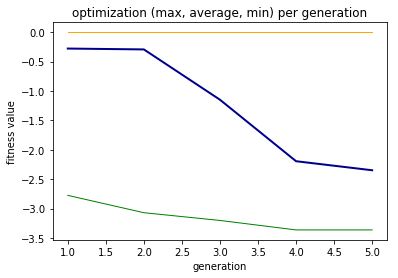

In [14]:
# Plot statistics about the optimization process
plot(logs.select('gen'), logs.select('max'), lw=1, color='orange')
plot(logs.select('gen'), logs.select('avg'), lw=2, color='darkblue')
plot(logs.select('gen'), logs.select('min'), lw=1, color='green')
title('optimization (max, average, min) per generation'); xlabel('generation'); ylabel('fitness value')